[![image-1.png](https://i.postimg.cc/HxFJ6c1w/image-1.png)](https://postimg.cc/XGc7JvJq)

<div style="padding:20px 30px 30px; 
            color:#004346;
            font-size:30px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Определение жанра по обложки музыкального диска</p>


</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 

    
Очевидно, что оформление музыкального альбома как-то связано с его содержанием. Но насколько связано? Как подтвердить это, опираясь на данные? И чем это может быть полезно?

__Постановка задачи:__ разработать модель, которая определит жанр музыкального альбома по изображению его обложки..
    
__Описание данных:__ Изображения в формате PNG, упакованные в zip-архивы. Имя архива соответствует музыкальному жанру. Каждый zip-архив содержит папку с изображениями музыкальных обложек одного из десяти жанров:
    
   - anime
   - black metal
   - classical
   - country
   - disco
   - edm
   - jazz
   - pop
   - rap 
   - reggae
    

__Оценка результата:__  Accuracy.
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from PIL import Image
import warnings
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sentence_transformers import SentenceTransformer, util

from fastai.vision.all import *
from fastai.learner import *
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.callback.tracker import SaveModelCallback

# константы
RANDOM_SEED = 42
BASE_PATH = 'data/' # корневая директория
IMAGES = os.path.join(BASE_PATH, 'images') # путь к фотографиям

# настройки блокнота
tqdm.pandas()
random.seed(RANDOM_SEED)
warnings.filterwarnings("ignore")

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка и общая информация данных

</div>

Давайте сначала создадим набор данных, в котором будут указаны пути к изображениям, а в качестве меток (таргетов) будем использовать названия папок, отражающих жанры музыки.

In [15]:
data = []

for genre in os.listdir(IMAGES): # получаем список папок
    genre_path = os.path.join(IMAGES, genre)
    if os.path.isdir(genre_path): # проверка действительности директории
        for filename in os.listdir(genre_path):
            file_path = os.path.join(genre_path, filename)
            data.append((file_path, genre)) # добавляем полный путь и название папки (жанр)
    else: print('Ошибка в формировании пути к файлу')

df = pd.DataFrame(data, columns=['file_path', 'genre'])

display(df.head(2))

,file_path,genre
0,data/images/pop/dea7825d-5cd5-4748-9fea-76bbe7...,pop
1,data/images/pop/3694c8b3-e7c4-4b2d-aacc-6588a5...,pop


Выведем насколько изображений:

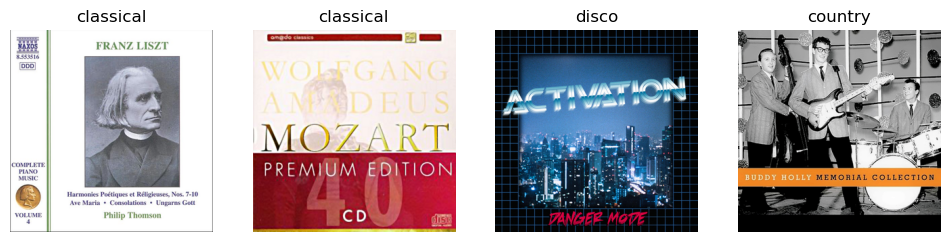

In [14]:
n_images = 4 # количество изображений

sample_images = df.sample(n_images, random_state=RANDOM_SEED) # выборка

# вывод изодражений
ig, axes = plt.subplots(1, n_images, figsize=(12, 4))
for i in range(n_images):
    image_path = sample_images.iloc[i, 0]
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f'{sample_images.iloc[i, 1]}')
    axes[i].axis('off')
plt.show()

## Баланс целевой переменной

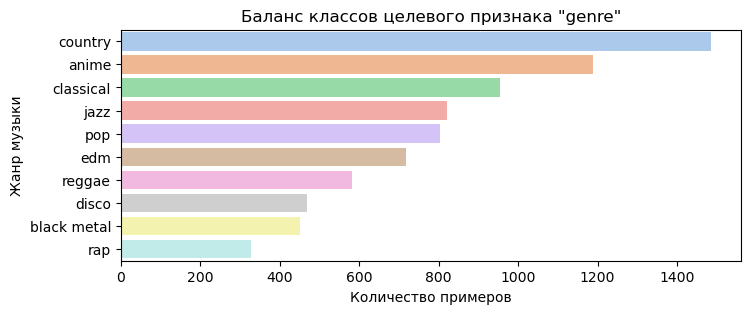

In [81]:
plt.figure(figsize=(8, 3))
sns.countplot(y='genre', data=df, palette='pastel', order=df['genre'].value_counts().index)
plt.title('Баланс классов целевого признака "genre"')
plt.xlabel('Количество примеров')
plt.ylabel('Жанр музыки')
plt.show()

>Изображения готовы к загрузке и анализу. 
>
>Важно помнить о дисбалансе в целевой переменной что надо учесть при обучении моделей.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  Обучение модели

</div>

Рассмотрим различные подходы к решению данной задачи

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  Baseline model

</div>


Для базового решения мы используем векторные представления, полученные с помощью предварительно обученной модели. Затем каждый пример из валидационного набора данных сравниваем со всеми объектами тренировочного набора данных, используя косинусное сходство. После этого мы присваиваем текущему объекту метку объекта из тренировочного набора данных с наибольшим косинусным сходством.

In [22]:
model = SentenceTransformer('clip-ViT-B-32') # предобученная модель

In [17]:
# получение эмбэденгов
df['embedding'] = df['file_path'].progress_apply(lambda x: model.encode(Image.open(x), batch_size=256))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7800/7800 [04:41<00:00, 27.67it/s]


In [28]:
df.to_csv(os.path.join(BASE_PATH, 'df_embeddings.csv'), index=False)

In [2]:
df = pd.read_csv(os.path.join(BASE_PATH, 'df_embeddings.csv'))

### Выделение выборок для обучения, валидации и тестирования

Разделим данные на обучающую, валидационную и тестувую выборки. На валидацию выделим 20%, на тестировании - 10% от исходных данных с сохранением баланса классов.

In [18]:
df_train, df_ = train_test_split(df, test_size=0.3, stratify=df['genre'], random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_, test_size=0.33, stratify=df_['genre'], random_state=RANDOM_SEED)

In [19]:
# размер наборов данных
print(f'Размер обучающего набора: {len(df_train)/len(df):.0%}')
print(f'Размер валидационного набора: {len(df_val)/len(df):.0%}')
print(f'Размер тестового набора: {len(df_test)/len(df):.0%}')

Размер обучающего набора: 70%
Размер валидационного набора: 20%
Размер тестового набора: 10%


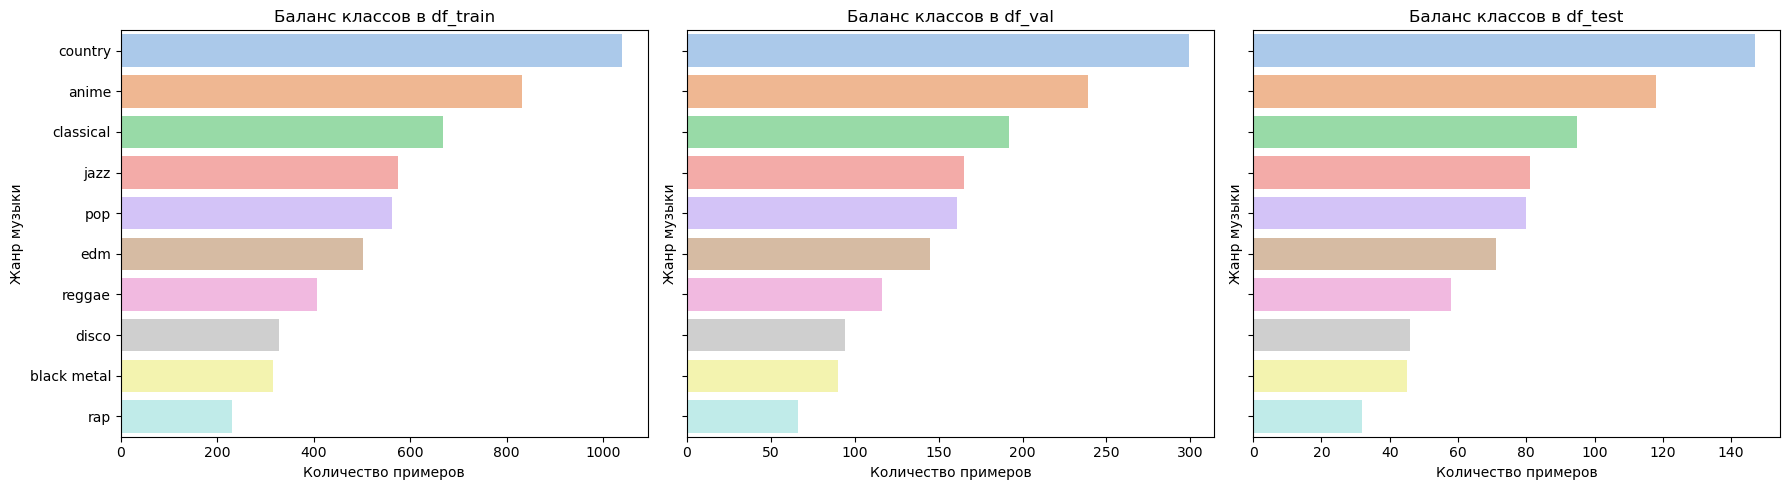

In [6]:
# баланс классов
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sns.countplot(y='genre', data=df_train, palette='pastel', order=df_train['genre'].value_counts().index, ax=axes[0])
axes[0].set_title('Баланс классов в df_train')
axes[0].set_xlabel('Количество примеров')
axes[0].set_ylabel('Жанр музыки')

sns.countplot(y='genre', data=df_val, palette='pastel', order=df_val['genre'].value_counts().index, ax=axes[1])
axes[1].set_title('Баланс классов в df_val')
axes[1].set_xlabel('Количество примеров')
axes[1].set_ylabel('Жанр музыки')

sns.countplot(y='genre', data=df_test, palette='pastel', order=df_test['genre'].value_counts().index, ax=axes[2])
axes[2].set_title('Баланс классов в df_test')
axes[2].set_xlabel('Количество примеров')
axes[2].set_ylabel('Жанр музыки')

plt.tight_layout()
plt.show()

> Полученные выборки были разделены в соотношении 70/20/10 с сохранением баланса классов.

In [76]:
# функция для определения максимально близкого вектора
def predict_sample(x):
    temporary_df = df_train.copy()
    temporary_df['cos_sim'] = temporary_df['embedding'].apply(lambda y: float(util.cos_sim(y, x['embedding'])))
    return temporary_df[temporary_df['cos_sim'] == temporary_df['cos_sim'].max()]['genre'].values[0]

In [77]:
# получение предсказаний
df_val['predict'] = df_val.progress_apply(predict_sample, axis=1)

100%|███████████████████████████████████████| 1567/1567 [02:36<00:00, 10.00it/s]


In [69]:
# подсчет метрик
report = classification_report(df_val['genre'], df_val['predict'])
accuracy = accuracy_score(df_val['genre'], df_val['predict'])

print(f'Accuracy: {accuracy}')
print('\nClassification Report:')
print(report)

Accuracy: 0.7906828334396937

Classification Report:
              precision    recall  f1-score   support

       anime       0.85      0.96      0.90       239
 black metal       0.83      1.00      0.90        90
   classical       0.95      0.95      0.95       192
     country       0.85      0.85      0.85       299
       disco       0.55      0.54      0.55        94
         edm       0.81      0.54      0.65       145
        jazz       0.72      0.72      0.72       165
         pop       0.63      0.61      0.62       161
         rap       0.80      0.80      0.80        66
      reggae       0.70      0.72      0.71       116

    accuracy                           0.79      1567
   macro avg       0.77      0.77      0.77      1567
weighted avg       0.79      0.79      0.79      1567



<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

##  Fastai

</div>

Fastai - это библиотека машинного обучения, построенная на базе PyTorch, которая предоставляет простой в использовании интерфейс для работы с нейронными сетями.

Для работы с изображениями мы можем использовать ImageDataLoaders, чтобы автоматически загрузить и подготовить данные для обучения модели. Мы можем выделить 20% данных для валидации, чтобы оценить производительность модели.

Чтобы сохранять лучшие версии модели во время обучения, мы можем использовать SaveModelCallback. Этот коллбэк позволяет сохранять модель наилучшего качества, чтобы потом можно было использовать ее для предсказаний или дальнейшего обучения.

Для предотвращения переобучения модели мы можем использовать EarlyStoppingCallback. Этот коллбэк автоматически прекращает обучение, если производительность модели на валидационном наборе перестает улучшаться, что помогает избежать переобучения и сохранить лучшую модель.

In [2]:
# проверяем доступность устройств для обучения модели
if torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Устройство для обучения модели: {device}')

Устройство для обучения модели: mps


In [3]:
# коллбэки
save_model_cb = SaveModelCallback(monitor='valid_loss', fname='best_model')
early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', patience=5)

# загрузка данных
dls = ImageDataLoaders.from_folder(BASE_PATH,     # директории, где хранятся изображения
                                   valid_pct=0.2, # процент данных, который будет использоваться для валидации
                                   bs=32,         # размер батча
                                   seed = RANDOM_SEED,
                                   device='mps',
                                   cbs=[save_model_cb, early_stopping_cb] # коллбэки
                                  )
display(dls.valid_ds.items[:3])

[Path('data/images/anime/5282cfb9-2fb6-4e25-b13b-f715cb16c6ad.png'),
 Path('data/images/disco/f96ad090-1700-432a-9215-35ebc28d32dd.png'),
 Path('data/images/pop/dea7825d-5cd5-4748-9fea-76bbe7d97253.png')]

In [12]:
# парыметры обучения
learn = vision_learner(dls, 
                       arch= vgg19_bn,    # используем vgg19_bn
                       normalize=True, 
                       pretrained=True,  # веса
                       metrics=accuracy)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /Users/denismuhanov/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|███████████| 548M/548M [01:21<00:00, 7.01MB/s]


__Оптимальная скорость обучения:__

SuggestedLRs(valley=0.0014454397605732083)

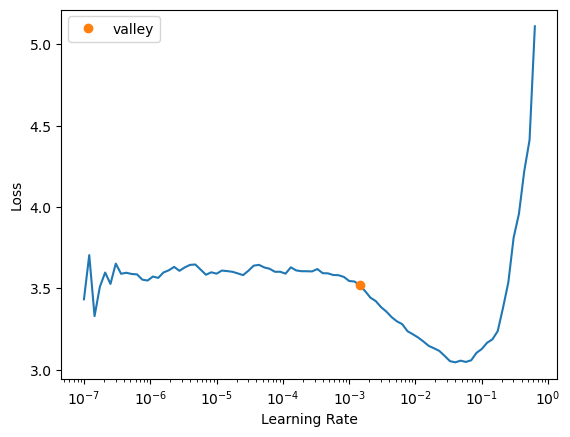

In [13]:
learn.lr_find()

In [14]:
optimal_lr = 0.0014454397605732083

__Обучение модели:__

In [15]:
learn.fit_one_cycle(15, lr_max=optimal_lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.487714,1.537013,0.512821,10:13
1,1.816309,1.270170,0.586538,15:23
2,1.539532,1.171975,0.613462,34:49
3,1.369973,1.180448,0.605128,14:49
4,1.270948,1.194608,0.615385,15:13
5,1.182995,1.172746,0.600000,15:10
6,1.086515,1.155329,0.608333,13:20
7,0.996118,1.131634,0.605769,13:54
8,0.859318,1.119278,0.630128,16:13
9,0.794853,1.155599,0.621795,15:55


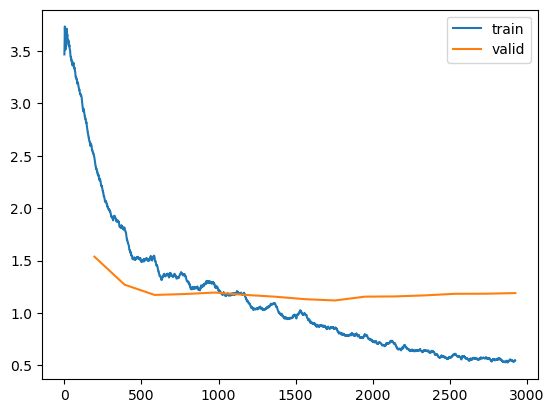

In [16]:
# график процесса обучения 
learn.recorder.plot_loss(skip_start=0, with_valid=True)

__Анализ модели__

> train_loss: Потери на обучающем наборе уменьшаются с каждой эпохой, что указывает на то, что модель успешно обучается и снижает ошибку на тренировочных данных.
>
>valid_loss: Потери на валидационном наборе данных сначала снижаются, а затем начинают немного возрастать после восьмой эпохи. Это может быть признаком переобучения модели, когда она начинает хорошо работать на тренировочных данных, но плохо обобщает свои знания на новые данные.
>
>accuracy: Точность модели на валидационном наборе данных увеличивается с каждой эпохой, что также указывает на успешное обучение. Однако, так как потери на валидационном наборе начинают расти после второй эпохи, стоит быть осторожным с интерпретацией точности, так как она может быть не такой высокой на новых данных.

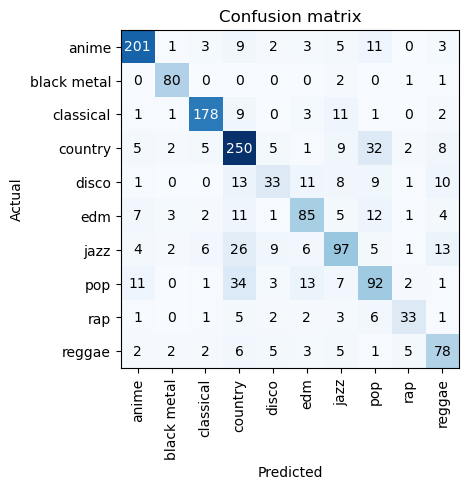

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

> Наибольшее количество ошибок модель совершает в классах pop и country

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

#  Вывод

</div>

В ходе работы были протестированы несколько предобученных моделей, включая resnet18, resnet50, vgg19_bn и squeezenet1_1. Однако, ни одна из них не показала значительного прироста в качестве по сравнению с базовым решением.

Это говорит о том, что выбор предобученной модели играет ключевую роль в достижении высокого качества обучения. В данном случае, возможно, стоит обратить внимание на другие архитектуры моделей или провести дополнительные эксперименты с настройками обучения.